In [1]:
from init import *
from utility import *
from repro import readfile
import os

os.environ["PROJ_LIB"] = os.path.join(os.environ["CONDA_PREFIX"], "share", "proj")
from mpl_toolkits.basemap import Basemap, addcyclic, cm

autotime loaded.
black loaded.
black loaded.
time: 935 ms


<IPython.core.display.Javascript object>

In [2]:
class Reprobus:
    def __init__(
        self, filename, nlev=60, nbcon=44, ncm=15, islev=np.arange(350, 801, 5)
    ):
        p0, rascp = 1000.0, 2.0 / 7.0
        self.nlev = nlev
        self.filename = filename
        self.date = pd.to_datetime(filename.split("_")[2], format="%Y%m%d%H")
        pj1, uj1, vj1, alt, tj1, qj1, hc = readfile(filename, nlev, nbcon, ncm)
        aa, bb = self.get_coeffs()
        pmb = np.zeros(tj1.shape)
        for i in np.arange(nlev):
            pmb[:, :, i] = aa[i] + bb[i] * pj1
        theta = tj1 * ((p0 / pmb) ** rascp)

        tr1 = {"Ozone": 4, "ClO": 10, "NO2": 6}
        tr2 = {
            "HNO3g": 42,
            "HNO3": 3,
            "N2O": 0,
            "POx": 10,
            "ClONO2": 13,
            "NOx": 20,
            "ClOx": 22,
            "BrOx": 23,
            "HCl": 12,
        }
        self.long_name = {
            "Ozone": "O$_3$",
            "ClO": "ClO",
            "HNO3g": "HNO$_3$ Gas",
            "HNO3": "HNO$_3$",
            "N2O": "N$_2$O",
            "NO2": "NO$_2$",
            "POx": "Passive Ox",
            "ClONO2": "ClONO$_2$",
            "NOx": "NO$_x$",
            "ClOx": "ClO$_x$",
            "BrOx": "BrO$_x$",
            "HCl": "HCl",
        }

        data = xr.Dataset()

        for k, v in tr1.items():
            data[k] = self.isentropic_tracers(hc[:, :, :, v], theta, islev, k)

        for k, v in tr2.items():
            data[k] = self.isentropic_tracers(qj1[:, :, :, v], theta, islev, k)

        self.data = data

    def get_coeffs(self, cdir="."):
        cfile = "%s/ecmwf_%s_levels.txt" % (cdir, self.nlev)
        df = pd.read_csv(cfile, sep="\s+", skiprows=[1])
        aa = 0.01 * df["a"].rolling(1).mean()[1:].values
        bb = df["b"].rolling(1).mean()[1:].values
        return aa, bb

    def isentropic_tracers(self, tmp, theta, islev, tr):
        lats = xr.DataArray(
            np.arange(90, -91, -2), dims="Latitude", attrs={"long_name": "Latitude"}
        )
        lons = xr.DataArray(
            np.arange(0, 360, 2), dims="Longitude", attrs={"long_name": "Longitude"}
        )
        levs = np.arange(nlev)  # [::-1]

        coords = [lons, lats, levs]
        dims = ["Longitude", "Latitude", "Level"]
        tattrs = {"long_name": "Temperature", "units": "K"}

        theta = xr.DataArray(theta, coords=coords, dims=dims, attrs=tattrs)
        islev = xr.DataArray(islev, dims="Theta", attrs=tattrs)
        tmp = xr.DataArray(tmp / 1e-9, dims=dims, coords=coords)
        tmp = xrvinterp(tmp, theta, islev, "Level", "Theta")
        tmp.attrs = {"long_name": "%s [ppbv]" % self.long_name[tr]}
        return tmp

time: 4.67 ms


<IPython.core.display.Javascript object>

In [11]:
def get_basemap(ax=None, min_lat=30):
    if not ax:
        fig, ax = facets(1, 1, width=10, aspect=0.6)
        ax = ax[0]
    m = Basemap(projection="spstere", lon_0=180, boundinglat=min_lat, round=True, ax=ax)
    m.drawcoastlines(linewidth=0.35)
    m.drawcountries(linewidth=0.35)
    m.drawmeridians(np.arange(0, 360, 60), labels=[0, 0, 0, 0])
    m.drawparallels(np.arange(20, 80, 20), labels=[1, 1, 0, 0])
    return m


def plot_data(molz, level=475, scale=1, min_lat=-45):
    fig, ax = plt.subplots(1, 1, figsize=(9, 7))
    cax = fig.add_axes([0.85, 0.2, 0.02, 0.6])
    m = get_basemap(ax=ax, min_lat=min_lat)
    data = molz.sel(Theta=level, method="nearest").T.values
    data, lon = addcyclic(data, molz["Longitude"])
    lat, lon = np.meshgrid(molz["Latitude"], lon)
    lon, lat = m(lon, lat)
    im = m.contourf(lon, lat, scale * data.T)
    cb = plt.colorbar(im, cax=cax, orientation="vertical")
    cb.set_label(label="%s" % (molz.attrs["long_name"]), size=18)
    return fig, ax, cb

time: 4.69 ms


<IPython.core.display.Javascript object>

In [4]:
nlev = 60
fname = "/media/pankaj/Data/reprobus/MODEL_history_2015050112_001410"
bus = Reprobus(fname, nlev)
bus.data

<xarray.Dataset>
Dimensions:    (Latitude: 91, Longitude: 180, Theta: 91)
Coordinates:
  * Longitude  (Longitude) int64 0 2 4 6 8 10 12 ... 346 348 350 352 354 356 358
  * Latitude   (Latitude) int64 90 88 86 84 82 80 78 ... -80 -82 -84 -86 -88 -90
  * Theta      (Theta) int64 350 355 360 365 370 375 ... 775 780 785 790 795 800
Data variables:
    Ozone      (Longitude, Latitude, Theta) float64 454.8 498.1 ... 2.644e+03
    ClO        (Longitude, Latitude, Theta) float64 0.0004028 ... 1.716e-07
    NO2        (Longitude, Latitude, Theta) float64 0.1133 0.126 ... 4.806 4.84
    HNO3g      (Longitude, Latitude, Theta) float64 1.283 1.388 ... 7.546 7.41
    HNO3       (Longitude, Latitude, Theta) float64 1.54 1.666 ... 16.29 16.24
    N2O        (Longitude, Latitude, Theta) float64 307.6 305.4 ... 9.218 8.737
    POx        (Longitude, Latitude, Theta) float64 465.7 511.7 ... 6.221e+03
    ClONO2     (Longitude, Latitude, Theta) float64 0.01985 0.02245 ... 0.4143
    NOx        (Longitude, Latitude, Theta) float64 0.1931 0.2108 ... 4.843
    ClOx       (Longitude, Latitude, Theta) float64 0.000403 ... 1.716e-07
    BrOx       (Longitude, Latitude, Theta) float64 0.001786 ... 2.074e-15
    HCl        (Longitude, Latitude, Theta) float64 0.3688 0.3997 ... 2.668 2.66

time: 41.8 s


<IPython.core.display.Javascript object>

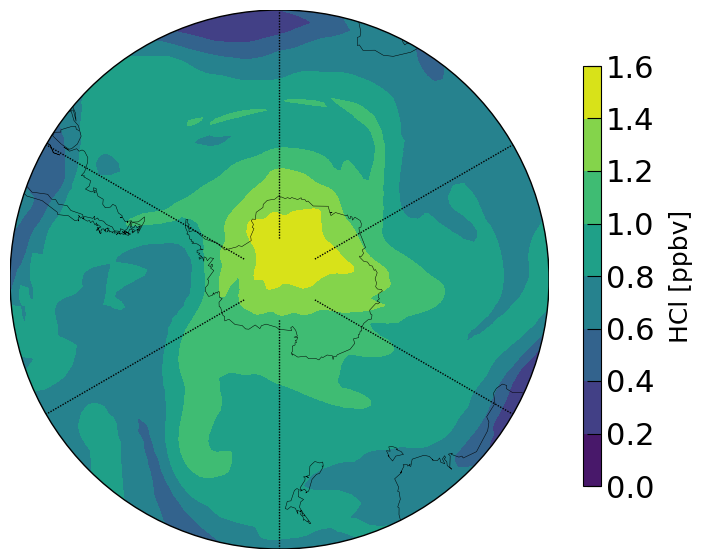

time: 414 ms


<IPython.core.display.Javascript object>

In [15]:
fig, ax, cb = plot_data(bus.data["HCl"], level=435, scale=1, min_lat=-30)
# cb.set_label(label="%s" % ("Ozone [ppmv]"), size=18)
plt.show()